# Thomas tri-diagonal method for 1-D BVP

Consider solving
$$
-u_{xx} = f(x), \qquad x \in [a,b]
$$
with boundary condition
$$
u(a) = \alpha, \qquad u(b) = \beta
$$

Make a partition of $n$ intervals with uniform spacing and grid points
$$
h = \frac{b-a}{n}, \qquad x_i = a + i h, \qquad i=0,1,\ldots,n
$$
The finite difference scheme is
\begin{eqnarray*}
u_0 &=& \alpha \\
-\frac{u_{i-1} - 2 u_i + u_{i+1}}{h^2} &=& f_i, \qquad i=1,2,\ldots,n-1 \\
u_n &=& \beta
\end{eqnarray*}
We can rewrite this as
\begin{eqnarray*}
u_0 &=& \alpha \\
-u_{i-1} + 2 u_i - u_{i+1} &=& h^2 f_i, \qquad i=1,2,\ldots,n-1 \\
u_n &=& \beta
\end{eqnarray*}
The above set of equations can be written as a matrix equation where the matrix is tridiagonal. 
$$
\left[\begin{array}{cccccc}
1 & 0 & 0 & 0 & \ldots & 0\\
-1 & 2 & -1 & 0 & \ldots & 0 \\
0 & -1 & 2 & -1 & \ldots & 0\\
\vdots & & & & & \vdots \\
0 & \ldots & 0 & -1 & 2 & -1 \\
0 & \ldots & \ldots & 0 & 0 & 1
\end{array}\right] \begin{bmatrix}
u_0 \\ u_1 \\ u_2 \\ \vdots \\ u_{n-1} \\ u_n \end{bmatrix} =
\begin{bmatrix}
\alpha \\ h^2 f_1 \\ h^2 f_2 \\ \vdots \\ h^2 f_{n-1} \\ \beta \end{bmatrix}
$$
We first implement Thomas algorithm but before that let us import some Python stuff.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from matplotlib import pyplot as plt

## Thomas Algorithm

Consider a tridiagonal matrix problem

$$
A x = f
$$

The general form of a $N \times N$ tridiagonal matrix is

$$
A = \left[\begin{array}{cccccc}
a_0 & c_0 & 0 & 0 & \ldots & 0\\
b_1 & a_1 & c_1 & 0 & \ldots & 0 \\
0 & b_2 & a_2 & c_2 & \ldots & 0\\
\vdots & & & & & \vdots \\
0 & \ldots & 0 & b_{N-2} & a_{N-2} & c_{N-2} \\
0 & \ldots & \ldots & 0 & b_{N-1} & a_{N-1}
\end{array}\right]
$$

We write this as the following LU decomposition

$$
A = \left[\begin{array}{cccccc}
\alpha_0 & 0 & 0 & 0 & \ldots & 0\\
b_1 & \alpha_1 & 0 & 0 & \ldots & 0 \\
0 & b_2 & \alpha_2 & 0 & \ldots & 0\\
\vdots & & & & & \vdots \\
0 & \ldots & 0 & b_{N-2} & \alpha_{N-2} & 0 \\
0 & \ldots & \ldots & 0 & b_{N-1} & \alpha_{N-1}
\end{array}\right]
\left[\begin{array}{cccccc}
1 & \gamma_0 & 0 & 0 & \ldots & 0\\
0 & 1 & \gamma_1 & 0 & \ldots & 0 \\
0 & 0 & 1 & \gamma_2 & \ldots & 0\\
\vdots & & & & & \vdots \\
0 & \ldots & 0 & 0 & 1 & \gamma_{N-2} \\
0 & \ldots & \ldots & 0 & 0 & 1
\end{array}\right]
$$

By matching the lhs with rhs, we can determine the $\alpha_i$ and $\gamma_i$

\begin{align}
\alpha_0 &= a_0 \\
\gamma_0 &= c_0/\alpha_0 \\
\alpha_i &= a_i - b_i \gamma_{i-1}, \quad \gamma_i = c_i/\alpha_i \qquad i=1,2,\ldots,N-2 \\
\alpha_{N-1} &= a_{N-1} - b_{N-1} \gamma_{N-2}
\end{align}

Actually there is no need to have separate arrays for $\alpha$, $\beta$. We will modify the $a$ and overwrite it with $\alpha$ and $c$ array will contain $\gamma$, while the $b$ array is unchanged. 

**Step 1.** The LU decomposition is given by

\begin{align}
c_0 &= c_0/a_0 \\
a_i &= a_i - b_i c_{i-1}, \quad c_i = c_i/a_i \qquad i=1,2,\ldots,N-2 \\
a_{N-1} &= a_{N-1} - b_{N-1} c_{N-2}
\end{align}

**Step 2.** Solve $Lx = f$

\begin{align}
x_0 &= f_0/a_0 \\
x_i &= \frac{1}{a_i}(f_i - b_i x_{i-1}), \qquad i=1,2,\ldots,N-1
\end{align}

**Step 3.** Solve $Ux = x$, i.e., we store the result in the same array $x$. 

$$
x_i = x_i - c_i x_{i+1}, \qquad i=N-2,N-3,\ldots,0
$$

We implement two functions; the first one computes the LU decomposition of the above matrix and the second one solves the matrix problem. 

In [8]:
# construct LU decomposition
def tdma1(a,b,c):
    n = len(a)
    c[0] = c[0]/a[0]
    for i in range(1,n):
        a[i] = a[i] - b[i]*c[i-1]
        c[i] = c[i]/a[i]
    a[n-1] = a[n-1] - b[n-1]*c[n-2]
    return a,b,c

# solve
def tdma2(a,b,c,f):
    n = len(f)
    x = np.empty_like(f)
    # solve L y = f
    x[0] = f[0]/a[0]
    for i in range(1,n):
        x[i] = (f[i] - b[i]*x[i-1])/a[i]
    # solve U x = y
    for i in range(n-2,-1,-1):
        x[i] = x[i] - c[i]*x[i+1]
    return x

## Solution of ODE

Choose
$$
f(x) = \sin(2\pi x), \qquad x \in [a,b] = [0,1]
$$
for which the exact solution is
$$
u(x) = \frac{1}{(2\pi)^2}\sin(2\pi x)
$$
and $\alpha = \beta = 0$. We now solve the problem by calling the above two functions.

Max error norm =  0.00013349155840115118


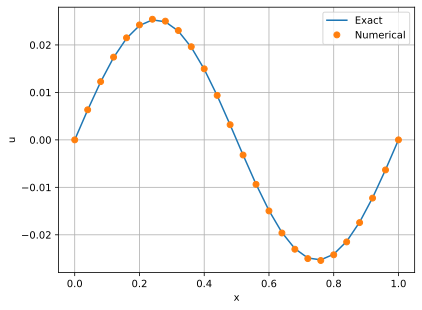

In [9]:
xmin, xmax = 0.0, 1.0
uexact = lambda x: np.sin(2*np.pi*x)/(2*np.pi)**2
frhs   = lambda x: np.sin(2*np.pi*x)

n = 25 # Number of intervals, so we have n+1 points
h = (xmax - xmin)/n

x = np.linspace(xmin, xmax, n+1) # Grid
f = h**2 * frhs(x)               # Right hand side
f[0] = uexact(xmin); f[n] = uexact(xmax);

# Create the three diagonals
a =  2.0*np.ones(n+1)
a[0] = 1.0; a[n] = 1.0

b = -1.0*np.ones(n+1)
b[n] = 0.0

c = -1.0*np.ones(n+1)
c[0] = 0.0

# Compute LU decomposition and solve the problem
a,b,c, = tdma1(a,b,c)
u = tdma2(a,b,c,f)

ue = uexact(x) # Exact solution

print('Max error norm = ',np.abs(u-ue).max())

plt.plot(x,ue,x,u,'o')
plt.xlabel('x'); plt.ylabel('u')
plt.grid(True)
plt.legend(("Exact","Numerical"));

## Exercise

Run the code for different number of grid points, $n=20,40,80,160,320$, and plot error versus $n$ in loglog scale. You should get a straight line with slope $-2$ indicating second order accuracy.